## Imports

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from tbats import TBATS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX
import holidays

## Import & prepare data

In [2]:
# Read in .csv files
df1 = pd.read_csv("FINAL1.csv", index_col='datetime', parse_dates=['datetime'])
df2 = pd.read_csv("FINAL2.csv", index_col='datetime', parse_dates=['datetime'])

# Add holiday information to the data set
us_holidays = holidays.US()
df1['is_holiday'] = df1.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)
df2['is_holiday'] = df1.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

# Split the data set along the right data ranges
df1 = df1[df1.index >= '2018-09-06 00:00:00']
df1_full = df1
df1 = df1[df1.index < '2020-03-01 00:00:00']
datasets = [df1, df1_full, df2]

# Create pandas.Series with the index & target values
df1_index_target = df1[['total minutes of parking']]
df1_full_index_target = df1_full[['total minutes of parking']]
df2_index_target = df2[['total minutes of parking']]

In [3]:
training_size = 0.8

# Split df1
split_point = int(len(df1_index_target) * training_size)
df1_train = df1[:split_point]
df1_test = df1[split_point:]

# Split df1_full
split_point = int(len(df1_full_index_target) * training_size)
df1_full_train = df1[:split_point]
df1_full_test = df1[split_point:]

# Split df2
split_point = int(len(df2_index_target) * training_size)
df2_train = df2[:split_point]
df2_test = df2[split_point:]

In [4]:
# Create columns that include transformed data
df1_train['transformed_data'] = df1_train['total minutes of parking'].map(lambda x: np.sqrt(x))
df1_full_train['transformed_data'] = df1_full_train['total minutes of parking'].map(lambda x: np.sqrt(x))
df2_train['transformed_data'] = df2_train['total minutes of parking'].map(lambda x: np.sqrt(x))

C:\Users\Felix\AppData\Local\Temp\ipykernel_8672\3080086331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_train['transformed_data'] = df1_train['total minutes of parking'].map(lambda x: np.sqrt(x))
C:\Users\Felix\AppData\Local\Temp\ipykernel_8672\3080086331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_full_train['transformed_data'] = df1_full_train['total minutes of parking'].map(lambda x: np.sqrt(x))
C:\Users\Felix\AppData\Local\Temp\ipykernel_8672\3080086331.py:4: SettingWithCopyWarni

## Plot data 

<Axes: xlabel='datetime'>

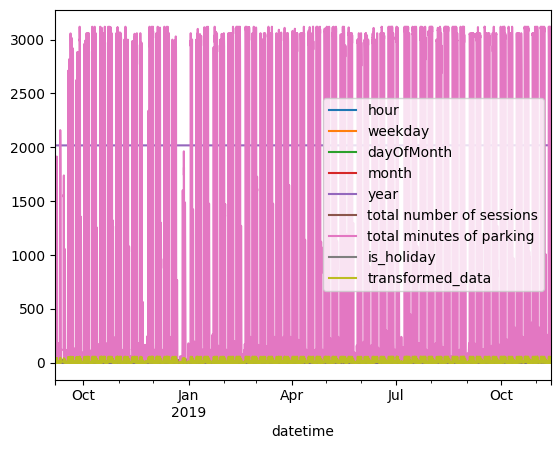

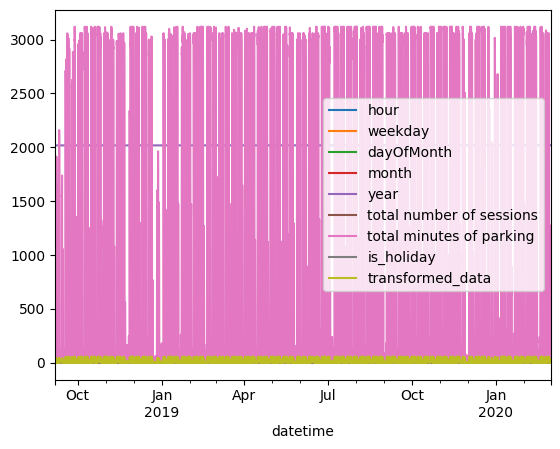

In [5]:
df1_train.plot()
df1_full_train.plot()

## STL Decomposition

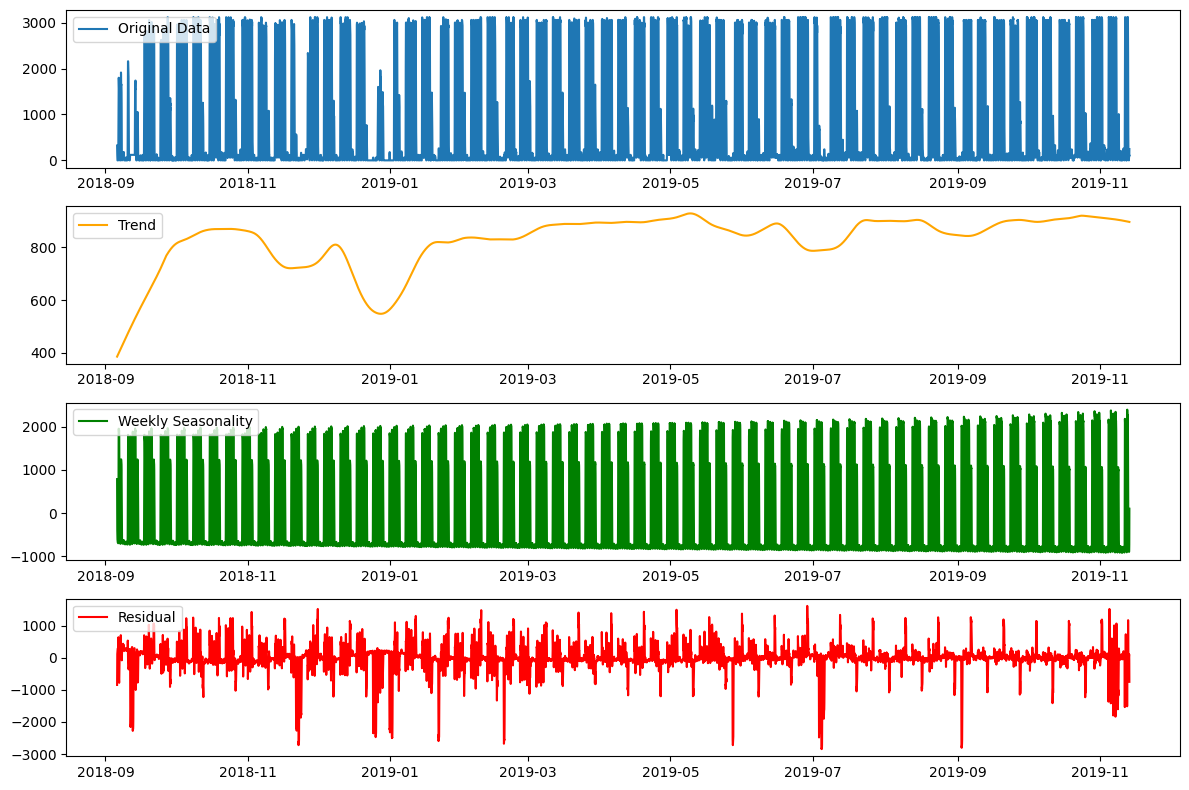

In [82]:
# Define input for STL decomposition
stl_input_df = df1_train[['total minutes of parking']]

# Apply STL for weekly seasonality
stl_model = STL(stl_input_df, period=24*7, seasonal=101, trend= 1001)
stl_result = stl_model.fit()

# Extract components
stl_trend = stl_result.trend
stl_seasonal_w = stl_result.seasonal
stl_residual_wow = stl_result.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(stl_input_df, label="Original Data")
plt.legend(loc="upper left")

plt.subplot(4, 1, 2)
plt.plot(stl_input_df.index, stl_trend, label="Trend", color="orange")
plt.legend(loc="upper left")

plt.subplot(4, 1, 3)
plt.plot(stl_input_df.index, stl_seasonal_w, label="Weekly Seasonality", color="green")
plt.legend(loc="upper left")

plt.subplot(4, 1, 4)
plt.plot(stl_input_df.index, stl_residual_wow, label="Residual", color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

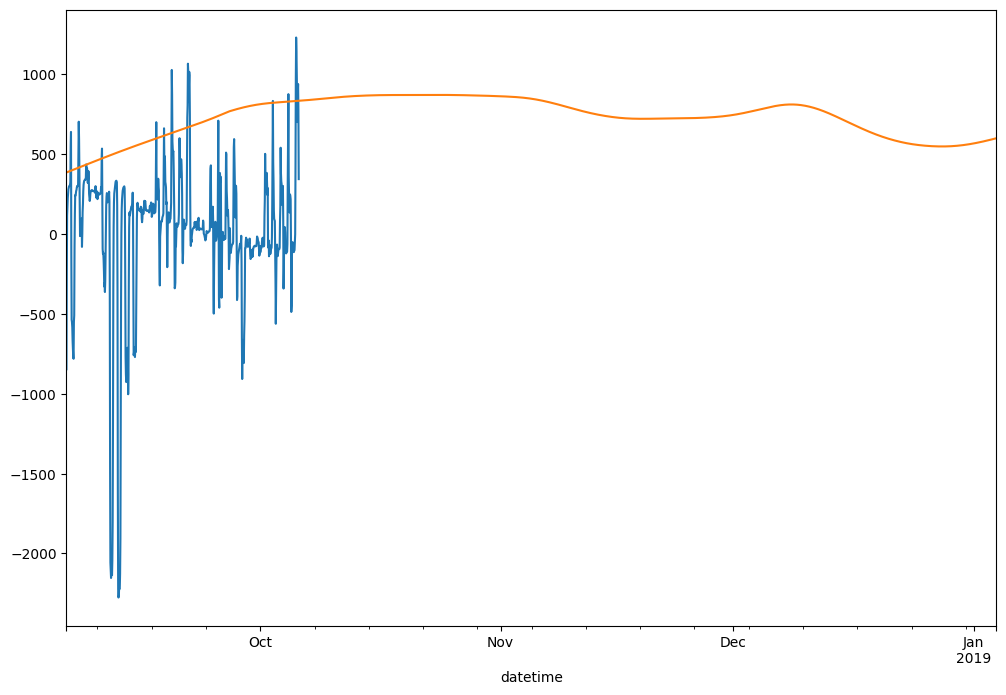

In [83]:
# Detailed inspection of residuals
plt.rcParams["figure.figsize"] = (12,8)
stl_residual_wow[:24*30].plot();
#stl_seasonal_w[:24*120].plot();
stl_trend[:24*120].plot();

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24*7).mean()
    rolstd = timeseries.rolling(window=24*7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [9]:
adf_test = adfuller(stl_residual_wow)
print(f'p-value: {adf_test[1]}')

p-value: 1.2944767615899736e-21


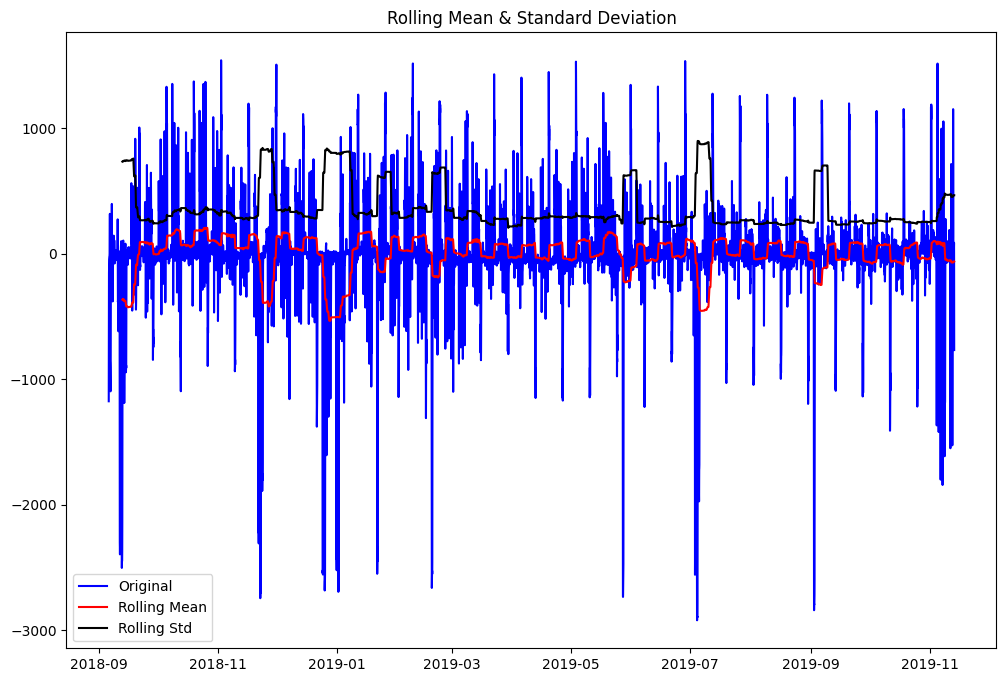

Results of Dickey-Fuller Test:

Test Statistic                -1.173790e+01
p-value                        1.294477e-21
#Lags Used                     3.800000e+01
Number of Observations Used    1.036700e+04
Critical Value (1%)           -3.430981e+00
Critical Value (5%)           -2.861819e+00
Critical Value (10%)          -2.566918e+00
dtype: float64


In [10]:
test_residual = stl_residual_wow
test_stationarity(test_residual)

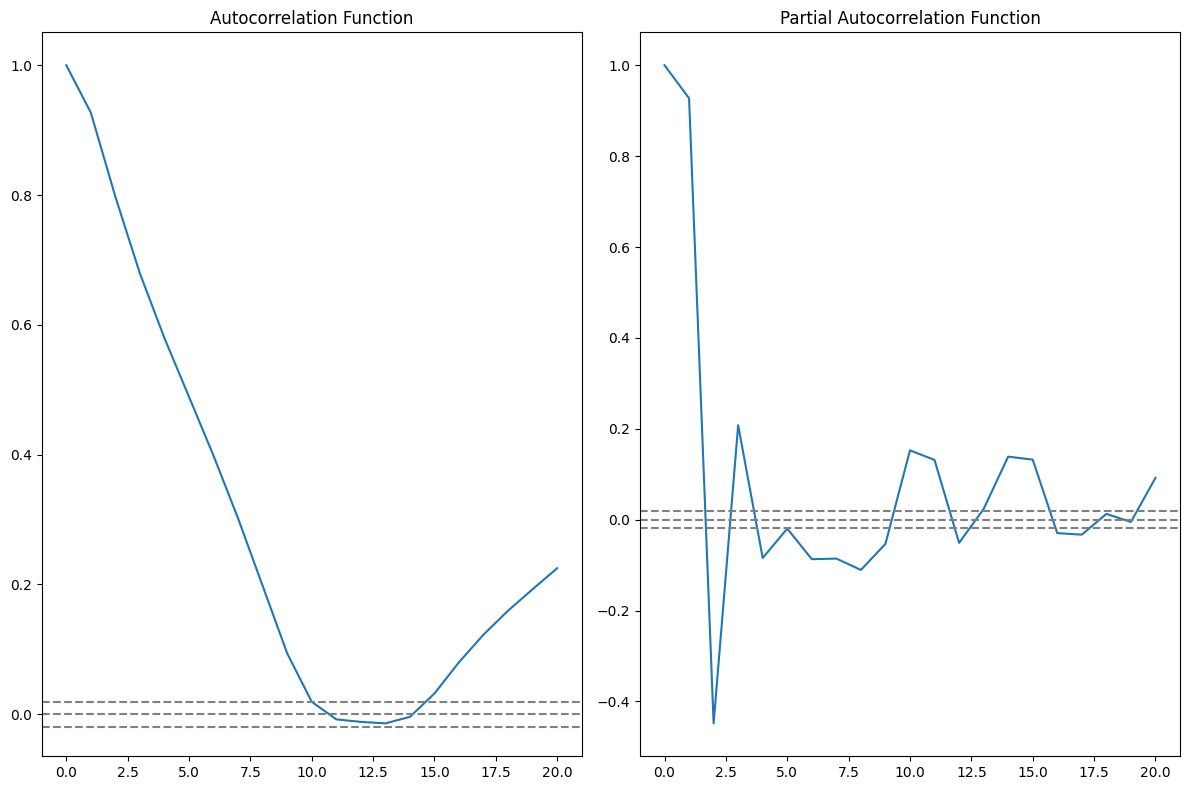

In [11]:
lag_acf = acf(stl_residual_wow, nlags=20)
lag_pacf = pacf(stl_residual_wow, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stl_residual_wow)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stl_residual_wow)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(stl_residual_wow)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(stl_residual_wow)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## MSTL Decomposition

In [77]:
# Define input for MSTL decomposition
mstl_input_df = df1_train[['total minutes of parking']]

#Define STL parameters for MSTL decomposition
stl_kwargs = {"seasonal_deg": 0, 'trend_deg': 0, 'trend': 24*30+1}

# Run MSTL decomposition
mstl_model = MSTL(mstl_input_df, periods=(24, 24 * 7), windows=(25,169), stl_kwargs = stl_kwargs)
mstl_result = mstl_model.fit()
mstl_seasonal = mstl_result.seasonal
mstl_seasonal_d = mstl_result.seasonal['seasonal_24']
mstl_seasonal_w = mstl_result.seasonal['seasonal_168']
#mstl_seasonal_y = mstl_result.seasonal['seasonal_8760']
mstl_trend = mstl_result.trend
mstl_residual = mstl_result.resid

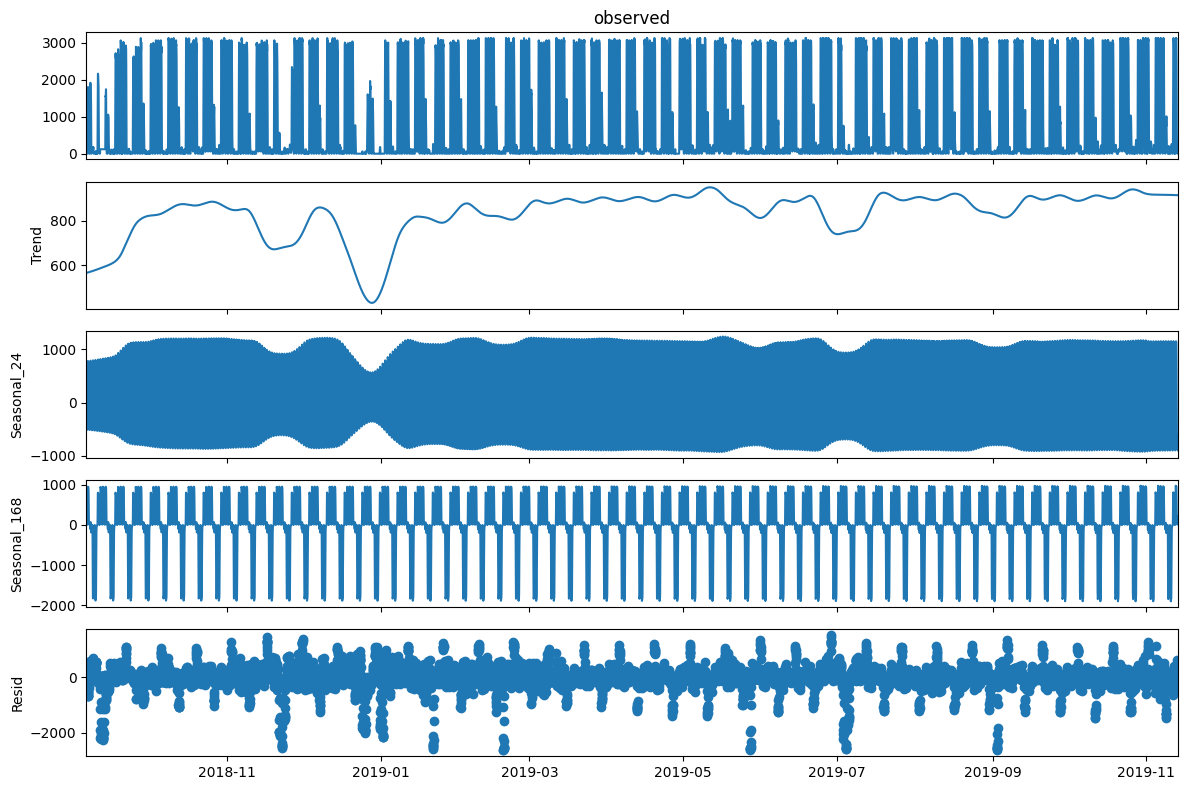

In [78]:
# Plot the results of the MSTL decomposition
plt.rcParams["figure.figsize"] = (12,8)
mstl_result.plot();

In [14]:
# # Detailed inspection of residuals
# plt.rcParams["figure.figsize"] = (12,8)
# mstl_residual[:24*30].plot();

## ARIMA models

In [15]:
# Define the ARIMA input data
arima_input_df = stl_residual_wow

In [16]:
# Grid search for best ARIMA model
stepwise_model = auto_arima(arima_input_df,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=True, trace=True,
                            error_action='ignore', suppress_warnings=True)

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=131981.427, Time=2.07 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=155240.249, Time=0.30 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=134763.135, Time=0.93 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=143724.038, Time=3.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155238.255, Time=0.19 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=131916.271, Time=3.01 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=132432.914, Time=1.68 sec


c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [17]:
# Create ARIMA model
order = (3,0,5) #stepwise_model.order
arima_model = ARIMA(arima_input_df, order=order, freq='h')
arima_result = arima_model.fit()

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 185147202.3832')

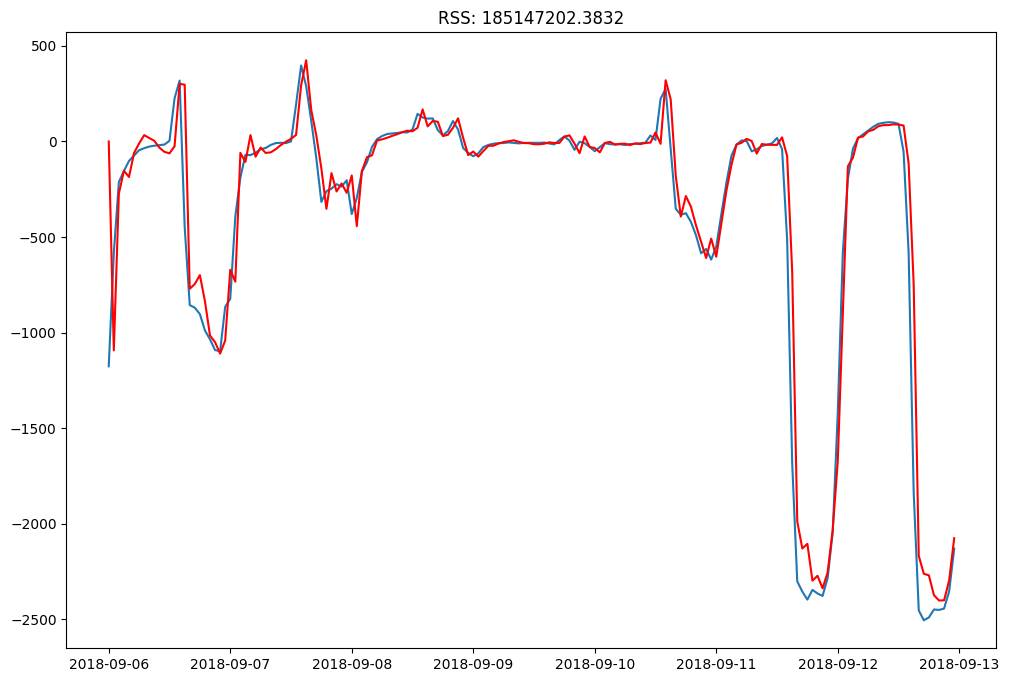

In [18]:
plt.plot(arima_input_df[:24*7])
plt.plot(arima_result.fittedvalues[:24*7], color='red')
plt.title('RSS: %.4f'% sum((arima_result.fittedvalues-arima_input_df)**2))

## SARIMAX model

In [85]:
# Define the SARIMAX input data
sarimax_input_df = stl_residual_wow

# Define the exogenos variables
exog = df1_train[['is_holiday']]

In [ ]:
# # Grid search for best SARIMAX model
# stepwise_model = auto_arima(y=sarimax_input_df,
#                             m=24,
#                             start_p=1, start_q=1,
#                             max_p=3, max_q=3,
#                             seasonal=True, trace=True,
#                             error_action='ignore', suppress_warnings=True)

In [29]:
# Create SARIMAX model
sarimax_model = SARIMAX(sarimax_input_df, exog=exog, order=(3,0,5), seasonal_order=(1,1,1,24), freq='h')
sarimax_result = sarimax_model.fit()

c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Felix\AA_Project_New\AA2024\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Create SARIMAX model with weather data 
sarimax_model_w = SARIMAX(sarimax_input_df, exog=exog, order=(3,0,5), seasonal_order=(1,1,1,168), freq='h')
sarimax_w_result = sarimax_model.fit()

## Forecast

Forecast Trend with polynomial regression

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def forecast_trend(trend_component, forecast_horizon):
    # Step 2: Prepare polynomial features
    time_trend = np.arange(len(trend_component)).reshape(-1, 1)  # Time indices for the trend
    future_time = np.arange(len(trend_component), (len(trend_component) + forecast_horizon)).reshape(-1, 1)  # Forecast horizon

    # Create polynomial features (degree=2 for quadratic, can be adjusted)
    poly = PolynomialFeatures(degree=2)
    time_trend_poly = poly.fit_transform(time_trend)
    future_time_poly = poly.transform(future_time)

    # Step 3: Fit polynomial regression model
    model = LinearRegression()
    model.fit(time_trend_poly, trend_component)

    # Step 4: Forecast the trend
    trend_forecast = model.predict(future_time_poly)

    # Step 5: Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(trend_component, label='Observed Trend', marker='o')
    plt.plot(trend_forecast, label='Forecasted Trend', marker='x')
    plt.title('Trend Forecast with Polynomial Regression')
    plt.legend()
    plt.show()

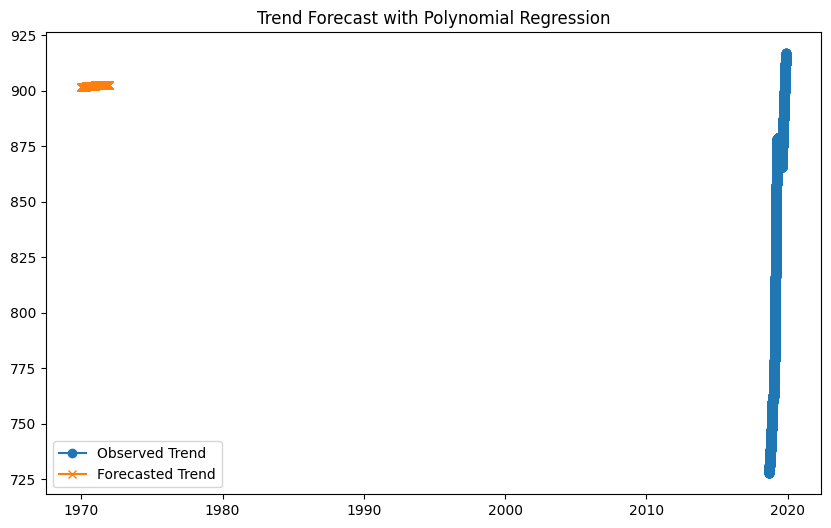

ValueError: x, y, and format string must not be None

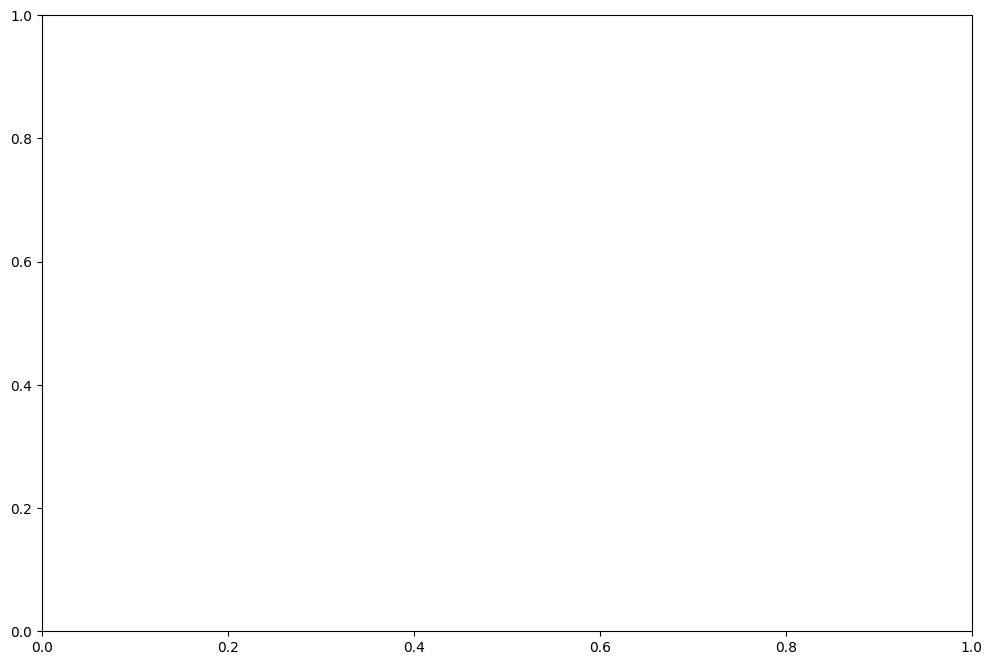

In [42]:
trend_forecast = forecast_trend(stl_trend, 24*30)
plt.plot(trend_forecast)

In [30]:
predictions_ARIMA_log = pd.Series(0, index=arima_input_df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(sarimax_result.fittedvalues, fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(stl_trend, fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(stl_seasonal_w, fill_value=0)
predictions_ARIMA_log.head()

datetime
2018-09-06 00:00:00    1499.756293
2018-09-06 01:00:00     533.885169
2018-09-06 02:00:00      88.096238
2018-09-06 03:00:00     -35.128056
2018-09-06 04:00:00     -62.956426
dtype: float64

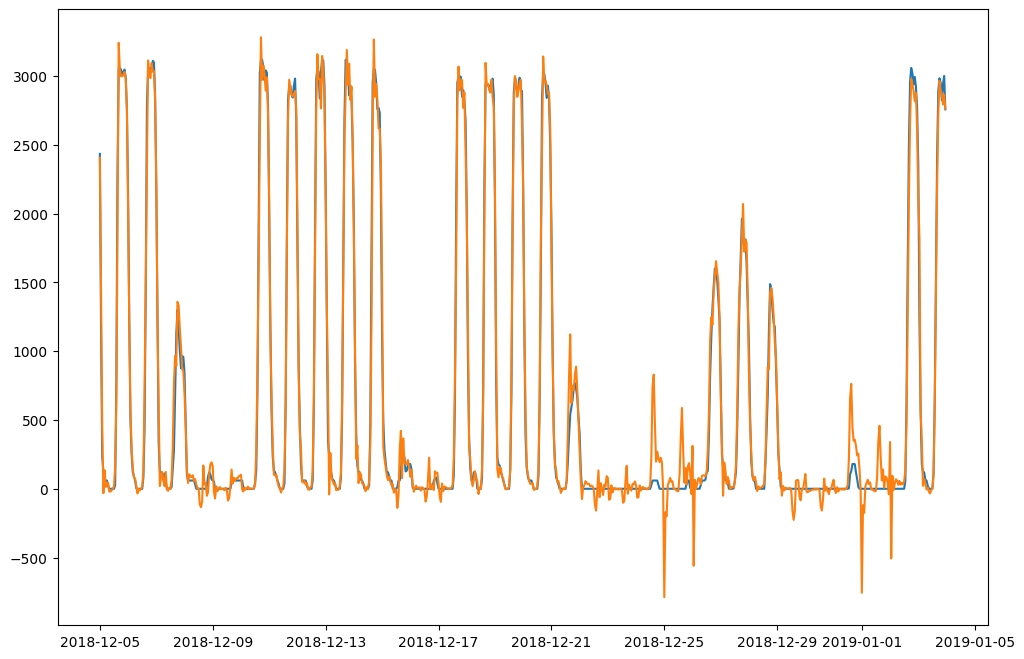

In [31]:
predictions_ARIMA = predictions_ARIMA_log.map(lambda x: int(x))
plt.plot(df1_train[['total minutes of parking']][24*90:24*120])
plt.plot(predictions_ARIMA[24*90:24*120])
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df1_train[['total minutes of parking']])**2)/len(df1_train)))

In [ ]:
# Define forecast horizon
forecast_horizon = 24*90
forecast_index = pd.date_range(start=df1_train.index[-1], periods=forecast_horizon + 1, freq="h")[1:]

# Define holidays for forecast horizon
exog_holidays = forecast_index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

# Define forecast model
forecast_model = sarimax_result

# Forecast residuals
forecast_residual = forecast_model.forecast(steps=forecast_horizon, exog=exog_holidays)


# Forecast weekly pattern
forecast_weekly = stl_seasonal_w[-168:] 
forecast_weekly = np.tile(forecast_weekly, int(np.ceil(forecast_horizon / 168)))[:forecast_horizon]

forecast = forecast_residual + forecast_weekly + 800
forecast = forecast.clip(lower=0)

In [1]:
# Plot the forecast 
#plt.plot(stl_input_df.index[-forecast_horizon:], stl_input_df[-forecast_horizon:], label='Observed Trend')
#plt.plot(forecast_index, forecast, label='Forecasted Trend', linestyle='--')
plt.plot(forecast_index, df1_test['total minutes of parking'][:forecast_horizon], label='Observed Trend')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

## Evaluation

In [62]:
def evaluate(data, forecast, forecast_horizon):    
    # Example ground truth (actual values)
    actual = data[:forecast_horizon]
    forecast = forecast[:forecast_horizon]

    # Compute errors
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"MAPE: {mape:.3f}%")

In [63]:
evaluate(df1_test[['total minutes of parking']], forecast, 7*24)

MAE: 235.826
MSE: 152986.211
MAPE: nan%
